# Importing Libraries
___

In [6]:
!pip install torch_geometric

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, global_mean_pool

import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Data Relabelling
___

In [8]:
def relabel_dataset(dataset_path, output_path):
    print(f"Relabeling {dataset_path} -> {output_path}...")
    try:
        graph_list = torch.load(dataset_path, weights_only=False)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    reprocessed_graphs = []
    
    for data in tqdm(graph_list, desc="Processing Graphs"):
        num_nodes = data.x.shape[0]
        edges = data.edge_index.t().numpy()
        
        if data.edge_attr.shape[0] != edges.shape[0]:
            continue

        distances = data.edge_attr[:, 0].numpy()
        states = data.edge_attr[:, 1].numpy()
        
        G = nx.DiGraph()
        G.add_nodes_from(range(num_nodes))
        
        for i, (u, v) in enumerate(edges):
            weight = float(distances[i])
            if states[i] == 2: weight *= 10000.0 
            elif states[i] == 1: weight *= 5.0
            G.add_edge(u, v, weight=weight, original_idx=i)

        try:
            meta = data.meta
            if isinstance(meta, dict):
                assemblies = meta['assembly_node_ids']
                survivors = meta['survivor_node_ids']
            else:
                assemblies = meta.assembly_node_ids
                survivors = meta.survivor_node_ids
        except:
            continue

        if not assemblies or not survivors: continue

        current_node = assemblies[0]
        unvisited = set(survivors)
        path_edges_indices = set()
        current_arrival_time = 0.0
        
        node_features = data.x.numpy() # [type, urgency, count]

        while unvisited:
            best_next = None
            best_score = float('inf')
            best_dist = 0.0
            
            for target in unvisited:
                try:
                    dist = nx.shortest_path_length(G, current_node, target, weight='weight')
                    urgency = max(1.0, node_features[target][1])
                    count = max(1.0, node_features[target][2])
                    
                    arrival_time = current_arrival_time + dist
                    score = arrival_time / ((urgency**2) + count)
                    
                    if score < best_score:
                        best_score = score
                        best_next = target
                        best_dist = dist
                except nx.NetworkXNoPath:
                    continue
            
            if best_next is None:
                break
            
            try:
                path = nx.shortest_path(G, current_node, best_next, weight='weight')
                for u, v in zip(path[:-1], path[1:]):
                    if G.has_edge(u, v):
                        idx = G[u][v]['original_idx']
                        path_edges_indices.add(idx)
                current_node = best_next
                current_arrival_time += best_dist
                unvisited.remove(best_next)
            except:
                break

        try:
            best_return = float('inf')
            return_node = None
            for asm in assemblies:
                try:
                    d = nx.shortest_path_length(G, current_node, asm, weight='weight')
                    if d < best_return:
                        best_return = d
                        return_node = asm
                except:
                    continue
            
            if return_node is not None:
                path = nx.shortest_path(G, current_node, return_node, weight='weight')
                for u, v in zip(path[:-1], path[1:]):
                    if G.has_edge(u, v):
                        idx = G[u][v]['original_idx']
                        path_edges_indices.add(idx)
        except:
            pass

        new_y = torch.zeros(data.edge_index.shape[1], dtype=torch.float)
        if path_edges_indices:
            new_y[list(path_edges_indices)] = 1.0
        
        new_edge_attr = data.edge_attr.clone()
        new_edge_attr[:, 0] = torch.log1p(new_edge_attr[:, 0])

        num_pos = new_y.sum().item()
        num_neg = new_y.shape[0] - num_pos
        pos_weight = torch.tensor([num_neg / max(num_pos, 1.0)], dtype=torch.float)

        data.y = new_y
        data.edge_attr = new_edge_attr
        data.pos_weight = pos_weight
        
        reprocessed_graphs.append(data)

    torch.save(reprocessed_graphs, output_path)
    print(f"Saved {len(reprocessed_graphs)} clean graphs to {output_path}")

In [9]:
relabel_dataset("/kaggle/input/rescunet-graph-data/graphs.pt", "graphs_cleaned.pt")

Relabeling /kaggle/input/rescunet-graph-data/graphs.pt -> graphs_cleaned.pt...


Processing Graphs: 100%|██████████| 1846/1846 [01:12<00:00, 25.43it/s]


Saved 1846 clean graphs to graphs_cleaned.pt


# RescuNet GNN
___

In [10]:
class RescuNet(nn.Module):
    def __init__(self, hidden_dim: int = 64) -> None:
        super().__init__()

        self.emb = nn.Embedding(3, hidden_dim)

        self.proj = nn.Linear(2, hidden_dim)

        self.node_encoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
        )

        self.edge_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        self.conv1 = GINEConv(
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
            ),
            edge_dim=hidden_dim
        )
        
        self.conv2 = GINEConv(
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
            ),
            edge_dim=hidden_dim
        )
        
        self.conv3 = GINEConv(
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
            ),
            edge_dim=hidden_dim
        )

        self.decoder = nn.Sequential(
            nn.Linear(3 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, x, edge_index, edge_attr, batch):
        node_types = x[:, 0].long()
        node_nums = x[:, 1:]

        emb = self.emb(node_types)
        proj = self.proj(node_nums)

        x = torch.cat([emb, proj], dim=1)
        x = self.node_encoder(x)

        edge_emb = self.edge_encoder(edge_attr)

        x = F.relu(self.conv1(x, edge_index, edge_attr=edge_emb)) + x
        x = F.relu(self.conv2(x, edge_index, edge_attr=edge_emb)) + x
        x = F.relu(self.conv3(x, edge_index, edge_attr=edge_emb)) + x

        row, col = edge_index
        edge_feat_final = torch.cat([x[row], x[col], edge_emb], dim=-1)

        logits = self.decoder(edge_feat_final).squeeze(-1)

        return logits

# Combined Loss
___

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, pos_weight=None):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        
        if pos_weight is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            weight_vector = targets * pos_weight + (1 - targets)
            focal_loss = alpha_t * (1 - pt) ** self.gamma * bce_loss * weight_vector
        else:
            focal_loss = (1 - pt) ** self.gamma * bce_loss
            
        return focal_loss.mean()

# Handling the Data
___

## Loading the Data

In [12]:
torch.serialization.add_safe_globals([Data, Batch])

graphs = torch.load("/kaggle/working/graphs_cleaned.pt", weights_only=False)

print(f"Total graphs: {len(graphs)}")
print(graphs[0])

Total graphs: 1846
Data(
  x=[1623, 3],
  edge_index=[2, 4094],
  edge_attr=[4094, 2],
  edge_label_binary=[4094],
  edge_label_continuous=[4094],
  coords=[1623, 2],
  meta={
    graph_id='graph_0',
    base_lat=29.7483062,
    base_lon=31.2200331,
    attempts_used=1,
    seeds_used=[1],
    assembly_node_ids=[2],
    survivor_node_ids=[3],
    valid=True,
    sanity_check_passed=True,
    num_tours=2,
    tours=[2],
  },
  y=[4094],
  pos_weight=[1]
)


## Splitting the Data

In [13]:
dataset_size = len(graphs)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(graphs, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Train graphs: {len(train_dataset)} | Val graphs: {len(val_dataset)}")

Train graphs: 1476 | Val graphs: 370


## Create the Data Loaders

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=4, shuffle=False)

# Training Objects
___

In [15]:
model = RescuNet(64)

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = FocalLoss(alpha=0.8, gamma=2.0)

# Training Config
___

In [17]:
epochs = 1000
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
best_f1 = float('-inf')
patience_counter = 0
patience = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training using {device}\n\n")
model.to(device)

Training using cuda




RescuNet(
  (emb): Embedding(3, 64)
  (proj): Linear(in_features=2, out_features=64, bias=True)
  (node_encoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
  )
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv2): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  ))
  (conv3): GINEConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_f

# Training Loop
___

In [18]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    y_true_train = []
    y_pred_train = []

    for data in train_loader:
        data = data.to(device)
        
        optimizer.zero_grad(set_to_none=True)

        logits = model(data.x, data.edge_index, data.edge_attr, data.batch)

        if hasattr(data, 'pos_weight') and data.pos_weight is not None:
            raw_weight = data.pos_weight.mean()
            pos_weight = torch.clamp(raw_weight, min=1.0, max=25.0)
        else:
            pos_weight = torch.tensor(10.0, device=device)

        loss = criterion(logits, data.y, pos_weight=pos_weight)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        running_loss += loss.item()

        preds = (torch.sigmoid(logits) > 0.5).long().cpu().numpy()
        targets = data.y.long().cpu().numpy()
        y_true_train.extend(targets)
        y_pred_train.extend(preds)
        
    avg_train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(y_true_train, y_pred_train, zero_division=0)
    train_prec = precision_score(y_true_train, y_pred_train, zero_division=0)
    train_rec = recall_score(y_true_train, y_pred_train, zero_division=0)
    
    train_losses.append(avg_train_loss)
    train_f1s.append(train_f1)
    
    model.eval()
    val_loss = 0.0
    y_true_val = []
    y_pred_val = []
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            logits = model(data.x, data.edge_index, data.edge_attr, data.batch)

            if hasattr(data, 'pos_weight') and data.pos_weight is not None:
                raw_weight = data.pos_weight.mean()
                pos_weight = torch.clamp(raw_weight, min=1.0, max=25.0)
            else:
                pos_weight = torch.tensor(10.0, device=device)
            
            loss = criterion(logits, data.y, pos_weight=pos_weight)
            val_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).long().cpu().numpy()
            targets = data.y.long().cpu().numpy()
            y_true_val.extend(targets)
            y_pred_val.extend(preds)

    
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)
    val_prec = precision_score(y_true_val, y_pred_val, zero_division=0)
    val_rec = recall_score(y_true_val, y_pred_val, zero_division=0)
    
    val_losses.append(avg_val_loss)
    val_f1s.append(val_f1)
    
    scheduler.step(avg_val_loss) 
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "rescunet.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}  |  Train Loss: {running_loss:.4f}  |  Val Loss: {best_f1:.4f}')
            break
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:4d}/{epochs}]")
        print(f"Train                 Loss: {avg_train_loss:.6f}  |  F1: {train_f1:.4f} (P:{train_prec:.2f} R:{train_rec:.2f})")
        print(f"Validation            Loss: {avg_val_loss:.6f}  |  F1: {val_f1:.4f} (P:{val_prec:.2f} R:{val_rec:.2f})")
        print("\n")

print(f"Training Complete! Best Validation F1: {best_f1:.6f}")

Epoch [   1/1000]
Train                 Loss: 0.108080  |  F1: 0.0497 (P:0.03 R:1.00)
Validation            Loss: 0.102700  |  F1: 0.0443 (P:0.02 R:1.00)


Epoch [  10/1000]
Train                 Loss: 0.090869  |  F1: 0.0634 (P:0.03 R:0.96)
Validation            Loss: 0.087041  |  F1: 0.0551 (P:0.03 R:0.98)


Epoch [  20/1000]
Train                 Loss: 0.085399  |  F1: 0.0662 (P:0.03 R:0.97)
Validation            Loss: 0.082486  |  F1: 0.0585 (P:0.03 R:0.98)


Epoch [  30/1000]
Train                 Loss: 0.084497  |  F1: 0.0673 (P:0.03 R:0.97)
Validation            Loss: 0.080896  |  F1: 0.0614 (P:0.03 R:0.98)


Epoch [  40/1000]
Train                 Loss: 0.084730  |  F1: 0.0680 (P:0.04 R:0.97)
Validation            Loss: 0.080738  |  F1: 0.0603 (P:0.03 R:0.98)


Epoch [  50/1000]
Train                 Loss: 0.083193  |  F1: 0.0690 (P:0.04 R:0.97)
Validation            Loss: 0.079752  |  F1: 0.0647 (P:0.03 R:0.96)


Epoch [  60/1000]
Train                 Loss: 0.083049  |  F1: 0

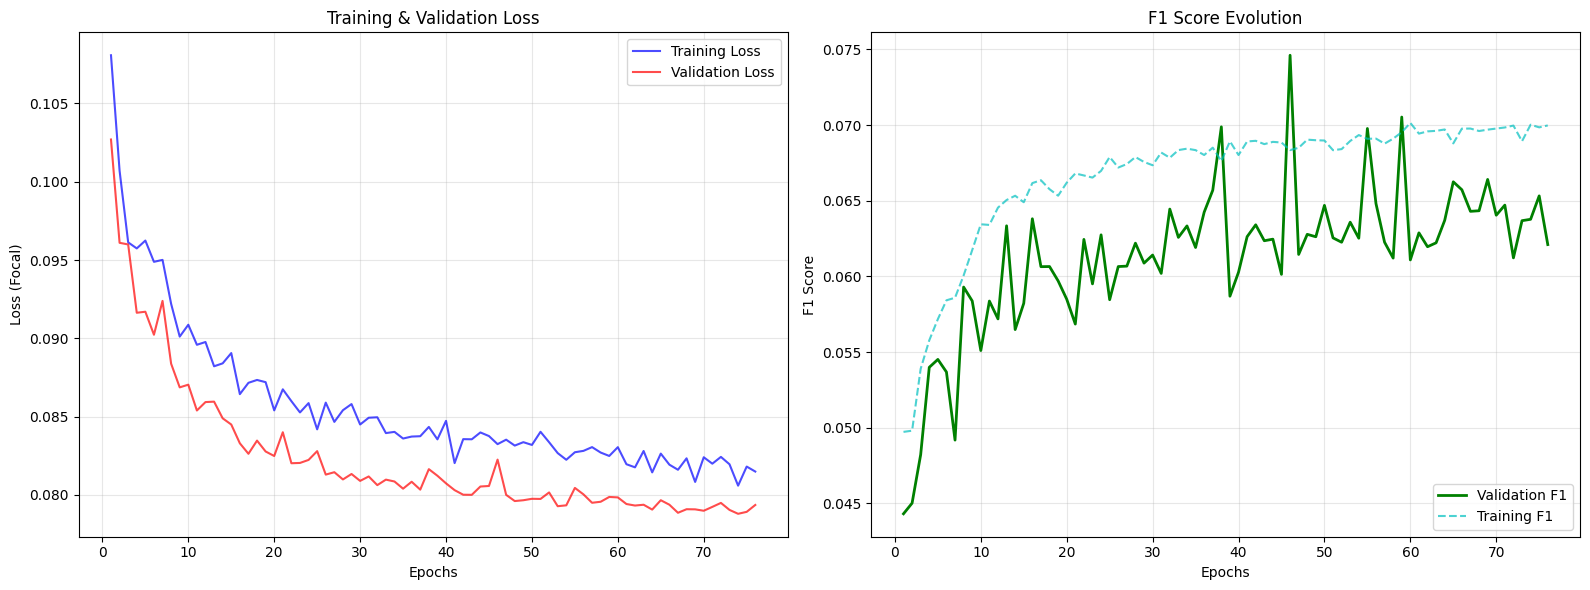

In [19]:
_epochs = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(_epochs, train_losses, 'b-', label='Training Loss', alpha=0.7)
ax1.plot(_epochs, val_losses, 'r-', label='Validation Loss', alpha=0.7)
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Focal)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(_epochs, val_f1s, 'g-', label='Validation F1', linewidth=2)
ax2.plot(_epochs, train_f1s, 'c--', label='Training F1', alpha=0.7)

ax2.set_title('F1 Score Evolution')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()